In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from pathlib import Path
from typing import Dict, Any, Set
from fd_analysis.prepare import filter_corrupt_files, get_python_projects, get_depsfiles, reduce_directory_levels

In [2]:
# import Biomedical's data

paths = "../data/results_biomed_20240423"

data_biomed, corrupt_biomed = filter_corrupt_files([Path(paths) / file for file in os.listdir(paths)])

print("Corrupt: ", corrupt_biomed)
len(data_biomed)


Corrupt:  []


1818

In [3]:
# Example data with no Python code - written in R
data_biomed["markerGeneProfile.json"]

{'metadata': {'project_name': 'markerGeneProfile',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/PavlidisLab/markerGeneProfile.git',
  'creation_timestamp': '2024-04-23T15:56:58.527634'},
 'code_dirs': None,
 'deps_file': [],
 'imports': []}

## Explore types of dependency declaration

### Identify Python projects

1142/1818 are Python projects

In [4]:
python_projects = get_python_projects(data_biomed) 
print("Number of Python projects: ", len(python_projects))

Number of Python projects:  1260


In [5]:
depsfiles = get_depsfiles(data_biomed)
depsfiles["4Dsurvival"]

732


[]

In [6]:
test = {        
    ".": {
            "py": 3,
            "ipynb": 0,
            "total": 3
        },
    "lib/pymice/_Python2": {
            "py": 3,
            "ipynb": 0,
            "total": 3
        },
        "lib/pymice/_Python3": {
            "py": 3,
            "ipynb": 0,
            "total": 3
        },
        "sphinx": {
            "py": 1,
            "ipynb": 0,
            "total": 1
        }}

rdl = reduce_directory_levels(test, {}, 2)
print(rdl)
rdl["lib/pymice"]


defaultdict(<function reduce_directory_levels.<locals>.<lambda> at 0x7ebb6c668670>, {'.': {'py': 3, 'ipynb': 0, 'total': 3}, 'lib/pymice': {'py': 6, 'ipynb': 0, 'total': 6}, 'sphinx': {'py': 1, 'ipynb': 0, 'total': 1}})


{'py': 6, 'ipynb': 0, 'total': 6}

In [7]:
codedirs = defaultdict(dict)
for d in data_biomed.values():
    if d["code_dirs"]:
        #reduced_directories = reduce_directory_levels(d["code_dirs"],d["deps_file"], 2)       
        reduced_directories = reduce_directory_levels(d["code_dirs"],d["deps_file"], 1)       
        for folder, source_type_dict in reduced_directories.items():
            folder_cleaned = "/".join([v.replace(d["metadata"]["project_name"].lower(), "PROJECT_NAME") for v in folder.lower().split("/")])
            codedirs[d["metadata"]["project_name"]] |= {(folder_cleaned, "py"): source_type_dict["py"], (folder_cleaned,"ipynb"): source_type_dict["ipynb"]}
    else:
        codedirs[d["metadata"]["project_name"]] = {}

df_codedirs = pd.DataFrame.from_dict(codedirs, orient="index")

python_projects = set(df_codedirs.index)
print("Number of Python projects: ", len(python_projects))
print("Projects without any Python files")

Number of Python projects:  1385
Projects without any Python files


In [8]:
(df_codedirs.xs('py', level=1, axis=1) + df_codedirs.xs('ipynb', level=1, axis=1)).sum(axis=1).sort_values(ascending=False)

osparc-simcore    2630.0
models            2611.0
galaxy            1976.0
pandas            1495.0
XlsxWriter        1351.0
                   ...  
biojava              1.0
reuteri              1.0
governance           1.0
snippy               1.0
esp-who              1.0
Length: 1385, dtype: float64

In [9]:
data_biomed["LeidenPDFhack.json"]

{'metadata': {'project_name': 'LeidenPDFhack',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/rossmounce/LeidenPDFhack.git',
  'creation_timestamp': '2024-04-23T17:29:11.625544'},
 'code_dirs': {'.': {'py': 1, 'ipynb': 0, 'total': 1}},
 'deps_file': [],
 'imports': []}

### Are folders specialized - either for Python files or for notebooks?

In [10]:
# Are folders specialized - either for Python files or for notebooks?

# How many subcolumns nave both nonzero values, compared to one column having zero value?

codedirs_py = df_codedirs.xs('py', level=1, axis=1)
codedirs_ipynb = df_codedirs.xs('ipynb', level=1, axis=1)

print("Python files only")
display(codedirs_py.head())
print("Notebooks only")
display(codedirs_ipynb.head())

codedirs_sum = codedirs_py + codedirs_ipynb

print("Sum of Python files and notebooks")
display(codedirs_sum.head())

only_py_df = (codedirs_ipynb == 0) & (codedirs_py > 0)
only_ipynb_df = (codedirs_ipynb > 0) & (codedirs_py == 0)
both_df = (codedirs_ipynb > 0) & (codedirs_py > 0)

Python files only


scripts  notebooks  notebooks-pc-linux  dna_puller   .  \
SSUsearch              29.0        0.0                 0.0         NaN NaN   
pytest                  5.0        NaN                 NaN         NaN NaN   
meyer_lungfish          7.0        NaN                 NaN         NaN NaN   
sim_and_scat            8.0        NaN                 NaN         NaN NaN   
PROFILE_BRAF_Model      1.0        NaN                 NaN         NaN NaN   

                    gnuplot_generator  lib  test  tutorial  sphinx  ...  \
SSUsearch                         NaN  NaN   NaN       NaN     NaN  ...   
pytest                            NaN  NaN   NaN       NaN     NaN  ...   
meyer_lungfish                    NaN  NaN   NaN       NaN     NaN  ...   
sim_and_scat                      NaN  NaN   NaN       NaN     NaN  ...   
PROFILE_BRAF_Model                NaN  NaN   NaN       NaN     NaN  ...   

                    isc_tutorial  two_population_PROJECT_NAME  n_t  starfish  \
SSUsearch                    NaN                          NaN  NaN       NaN   
pytest                       NaN                          NaN  NaN       NaN   
meyer_lungfish               NaN                          NaN  NaN       NaN   
sim_and_scat                 NaN                          NaN  NaN       NaN   
PROFILE_BRAF_Model           NaN                          NaN  NaN       NaN   

                    sptx_format  formatting_templates  pipeline_template  \
SSUsearch                   NaN                   NaN                NaN   
pytest                      NaN                   NaN                NaN   
meyer_lungfish              NaN                   NaN                NaN   
sim_and_scat                NaN                   NaN                NaN   
PROFILE_BRAF_Model          NaN                   NaN                NaN   

                    quantum  repo_management  maint_tools  
SSUsearch               NaN              NaN          NaN  
pytest                  NaN              NaN          NaN  
meyer_lungfish          NaN              NaN          NaN  
sim_and_scat            NaN              NaN          NaN  
PROFILE_BRAF_Model      NaN              NaN          NaN  

[5 rows x 1059 columns]

Notebooks only


scripts  notebooks  notebooks-pc-linux  dna_puller   .  \
SSUsearch               0.0       12.0                12.0         NaN NaN   
pytest                  0.0        NaN                 NaN         NaN NaN   
meyer_lungfish          0.0        NaN                 NaN         NaN NaN   
sim_and_scat            1.0        NaN                 NaN         NaN NaN   
PROFILE_BRAF_Model      0.0        NaN                 NaN         NaN NaN   

                    gnuplot_generator  lib  test  tutorial  sphinx  ...  \
SSUsearch                         NaN  NaN   NaN       NaN     NaN  ...   
pytest                            NaN  NaN   NaN       NaN     NaN  ...   
meyer_lungfish                    NaN  NaN   NaN       NaN     NaN  ...   
sim_and_scat                      NaN  NaN   NaN       NaN     NaN  ...   
PROFILE_BRAF_Model                NaN  NaN   NaN       NaN     NaN  ...   

                    isc_tutorial  two_population_PROJECT_NAME  n_t  starfish  \
SSUsearch                    NaN                          NaN  NaN       NaN   
pytest                       NaN                          NaN  NaN       NaN   
meyer_lungfish               NaN                          NaN  NaN       NaN   
sim_and_scat                 NaN                          NaN  NaN       NaN   
PROFILE_BRAF_Model           NaN                          NaN  NaN       NaN   

                    sptx_format  formatting_templates  pipeline_template  \
SSUsearch                   NaN                   NaN                NaN   
pytest                      NaN                   NaN                NaN   
meyer_lungfish              NaN                   NaN                NaN   
sim_and_scat                NaN                   NaN                NaN   
PROFILE_BRAF_Model          NaN                   NaN                NaN   

                    quantum  repo_management  maint_tools  
SSUsearch               NaN              NaN          NaN  
pytest                  NaN              NaN          NaN  
meyer_lungfish          NaN              NaN          NaN  
sim_and_scat            NaN              NaN          NaN  
PROFILE_BRAF_Model      NaN              NaN          NaN  

[5 rows x 1059 columns]

Sum of Python files and notebooks


scripts  notebooks  notebooks-pc-linux  dna_puller   .  \
SSUsearch              29.0       12.0                12.0         NaN NaN   
pytest                  5.0        NaN                 NaN         NaN NaN   
meyer_lungfish          7.0        NaN                 NaN         NaN NaN   
sim_and_scat            9.0        NaN                 NaN         NaN NaN   
PROFILE_BRAF_Model      1.0        NaN                 NaN         NaN NaN   

                    gnuplot_generator  lib  test  tutorial  sphinx  ...  \
SSUsearch                         NaN  NaN   NaN       NaN     NaN  ...   
pytest                            NaN  NaN   NaN       NaN     NaN  ...   
meyer_lungfish                    NaN  NaN   NaN       NaN     NaN  ...   
sim_and_scat                      NaN  NaN   NaN       NaN     NaN  ...   
PROFILE_BRAF_Model                NaN  NaN   NaN       NaN     NaN  ...   

                    isc_tutorial  two_population_PROJECT_NAME  n_t  starfish  \
SSUsearch                    NaN                          NaN  NaN       NaN   
pytest                       NaN                          NaN  NaN       NaN   
meyer_lungfish               NaN                          NaN  NaN       NaN   
sim_and_scat                 NaN                          NaN  NaN       NaN   
PROFILE_BRAF_Model           NaN                          NaN  NaN       NaN   

                    sptx_format  formatting_templates  pipeline_template  \
SSUsearch                   NaN                   NaN                NaN   
pytest                      NaN                   NaN                NaN   
meyer_lungfish              NaN                   NaN                NaN   
sim_and_scat                NaN                   NaN                NaN   
PROFILE_BRAF_Model          NaN                   NaN                NaN   

                    quantum  repo_management  maint_tools  
SSUsearch               NaN              NaN          NaN  
pytest                  NaN              NaN          NaN  
meyer_lungfish          NaN              NaN          NaN  
sim_and_scat            NaN              NaN          NaN  
PROFILE_BRAF_Model      NaN              NaN          NaN  

[5 rows x 1059 columns]


### How many projects have code directory with only Python files, only notebooks, or both?

In [11]:

def group_names(name):
    # Check if the name ends with 's'
    if name.endswith('s'):
        # If it does, return the singular form
        return name[:-1].lower()
    else:
        # If it doesn't, return the name as is
        return name.lower()


def group_codedirs(df, threshold=5):
    df = df.sum(axis=0)
    df = df.groupby(group_names).sum().sort_values(ascending=False)
    df = df[df >= threshold]
    return df

only_ipynb =  group_codedirs(only_ipynb_df)

only_py = group_codedirs(only_py_df)

both = group_codedirs(both_df)

len(only_ipynb), len(only_py), len(both)

(10, 22, 12)

### Directory structures grouping


In [12]:
print(df_codedirs.info())
df_codedirs.head()

depsfiles = defaultdict(list)
for d in data_biomed.values():
    if d["metadata"]["project_name"] in python_projects:
        if d["deps_file"]:
            depsfiles[d["metadata"]["project_name"]] = d["deps_file"]
        else:
            depsfiles[d["metadata"]["project_name"]] = {}

def check_dependencies_declaration(name: str) -> Set[str]:
    """
    Check the project named `name` declares dependencies and if yes, what types of parsers are used
    """
    return {dep["parser_choice"]for dep in depsfiles[name]}

<class 'pandas.core.frame.DataFrame'>
Index: 1385 entries, SSUsearch to analysis
Columns: 2118 entries, ('scripts', 'py') to ('maint_tools', 'ipynb')
dtypes: float64(2118)
memory usage: 22.4+ MB
None



#### Python soup projects

scripts  notebooks  notebooks-pc-linux  dna_puller   .  \
SSUsearch              29.0        0.0                 0.0         NaN NaN   
pytest                  5.0        NaN                 NaN         NaN NaN   
meyer_lungfish          7.0        NaN                 NaN         NaN NaN   
sim_and_scat            8.0        NaN                 NaN         NaN NaN   
PROFILE_BRAF_Model      1.0        NaN                 NaN         NaN NaN   

                    gnuplot_generator  lib  test  tutorial  sphinx  ...  \
SSUsearch                         NaN  NaN   NaN       NaN     NaN  ...   
pytest                            NaN  NaN   NaN       NaN     NaN  ...   
meyer_lungfish                    NaN  NaN   NaN       NaN     NaN  ...   
sim_and_scat                      NaN  NaN   NaN       NaN     NaN  ...   
PROFILE_BRAF_Model                NaN  NaN   NaN       NaN     NaN  ...   

                    isc_tutorial  two_population_PROJECT_NAME  n_t  starfish  \
SSUsearch                    NaN                          NaN  NaN       NaN   
pytest                       NaN                          NaN  NaN       NaN   
meyer_lungfish               NaN                          NaN  NaN       NaN   
sim_and_scat                 NaN                          NaN  NaN       NaN   
PROFILE_BRAF_Model           NaN                          NaN  NaN       NaN   

                    sptx_format  formatting_templates  pipeline_template  \
SSUsearch                   NaN                   NaN                NaN   
pytest                      NaN                   NaN                NaN   
meyer_lungfish              NaN                   NaN                NaN   
sim_and_scat                NaN                   NaN                NaN   
PROFILE_BRAF_Model          NaN                   NaN                NaN   

                    quantum  repo_management  maint_tools  
SSUsearch               NaN              NaN          NaN  
pytest                  NaN              NaN          NaN  
meyer_lungfish          NaN              NaN          NaN  
sim_and_scat            NaN              NaN          NaN  
PROFILE_BRAF_Model      NaN              NaN          NaN  

[5 rows x 1059 columns]

261
PerCent of all projects: 18.84 %
Percent of soup projects that have declaration: 15.33 %


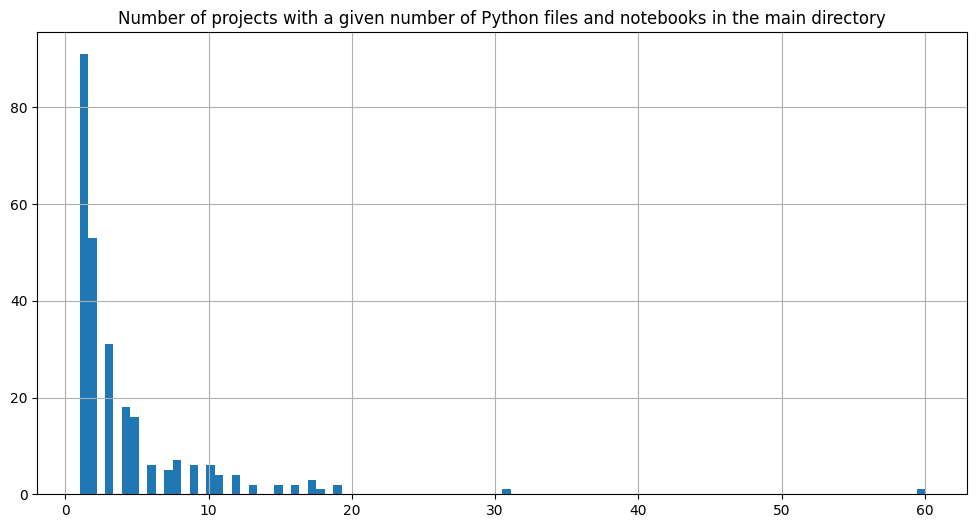

In [21]:
cond_soup = ((codedirs_ipynb['.'] > 0) | (codedirs_py['.'] > 0)) & \
             (codedirs_py.drop('.', axis=1).sum(axis=1) == 0) & (codedirs_ipynb.drop('.', axis=1).sum(axis=1) == 0)
soup_projects = (codedirs_py + codedirs_ipynb)[cond_soup].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
display(codedirs_py.head())
soup_projects.hist(bins=100, figsize=(12, 6))
plt.title("Number of projects with a given number of Python files and notebooks in the main directory")
soup_projects_index = soup_projects.index
print(len(soup_projects))
print(f"PerCent of all projects: {round(len(soup_projects) / len(df_codedirs) * 100, 2)} %")

deps_declaration_soup = [len(check_dependencies_declaration(name))>0 for name in soup_projects_index]
print(f"Percent of soup projects that have declaration: {round(sum(deps_declaration_soup) / len(soup_projects) * 100, 2)} %")



In [14]:
index_soup_2 = soup_projects[soup_projects["."] <=2].index

#### Projects with the same main folder as the project name

In [15]:

cond_same_name = (
    (codedirs_ipynb['PROJECT_NAME'] > 0) | (codedirs_py['PROJECT_NAME'] > 0)
    ) 
same_name_projects = (codedirs_py + codedirs_ipynb)[cond_same_name].dropna(axis=1, how='all')
same_name_projects_index = same_name_projects.index
print(len(same_name_projects))

deps_declaration_same_name = [len(check_dependencies_declaration(name))>0 for name in same_name_projects_index]
print(f"PerCent of all projects: {round(len(same_name_projects) / len(df_codedirs) * 100, 2)} %")
print(f"Percent of soup projects that have declaration: {round(sum(deps_declaration_same_name) / len(same_name_projects) * 100, 2)} %")



349
PerCent of all projects: 25.2 %
Percent of soup projects that have declaration: 94.84 %


In [16]:
# Check how many of them have `tests` directory

tested_same_name_projects = same_name_projects[((same_name_projects['tests'] > 0) | (same_name_projects['test'] > 0) | (same_name_projects['testing'] > 0))]  

print(f"Percent of tested projects 'same name' {round(len(tested_same_name_projects) / len(same_name_projects) * 100, 2)} %")

Percent of tested projects 'same name' 36.68 %


In [17]:

# some of those libs are notebook-heavy
same_name_notebooks_vs_py = pd.DataFrame.from_dict({"ipynb": codedirs_ipynb.loc[same_name_projects_index].sum(axis=1),
              "py":codedirs_py.loc[same_name_projects_index].sum(axis=1)}).sort_values(by="ipynb", ascending=False)
same_name_notebooks_vs_py["% notebooks"] = same_name_notebooks_vs_py["ipynb"] / same_name_notebooks_vs_py.sum(axis=1)
same_name_notebooks_vs_py.sort_values(by="% notebooks", ascending=False).head(20)


ipynb     py  % notebooks
ANEMO             100.0   25.0     0.800000
pyMolNetEnhancer    6.0    2.0     0.750000
bbknn               7.0    3.0     0.700000
CosinorPy          12.0    6.0     0.666667
visJS2jupyter       7.0    4.0     0.636364
MuMoT              17.0   10.0     0.629630
misas              11.0    8.0     0.578947
ponyo               6.0    5.0     0.545455
bootstrapped        8.0    7.0     0.533333
fastai            104.0   94.0     0.525253
DLITE              14.0   13.0     0.518519
nbdime             98.0   95.0     0.507772
PtitPrince          2.0    2.0     0.500000
MaBoSS_test         3.0    3.0     0.500000
RegSeq             17.0   18.0     0.485714
holoviews         306.0  345.0     0.470046
ddot                5.0    6.0     0.454545
pria_lifechem      37.0   45.0     0.451220
logomaker          15.0   19.0     0.441176
papermill          28.0   37.0     0.430769

#### Notebook-heavy
Not included prebviously, more than 80% are notebooks


In [18]:
cond_notebooks_heavy = (
    codedirs_ipynb.div(codedirs_sum).fillna(0)["notebooks"] > 0.8 ) | (codedirs_ipynb.div(codedirs_sum).fillna(0)["notebook"] > 0.8)
notebooks_heavy_projects = (codedirs_py + codedirs_ipynb)[cond_notebooks_heavy].dropna(axis=1, how='all')
notebooks_heavy_project_index = notebooks_heavy_projects.index
print(len(notebooks_heavy_projects))
print(f"PerCent of all projects: {round(len(notebooks_heavy_projects) / len(df_codedirs) * 100, 2)} %")

109
PerCent of all projects: 7.87 %


#### CATEGORY???

In [19]:
# take only those projects that are not categorised as same name or soup from df_codedirs


left = df_codedirs.drop(set(soup_project_index) | set(same_name_project_index)).dropna(axis=1, how='all')

cond_src = ((codedirs_ipynb['src'] > 0) | (codedirs_py['src'] > 0)) 
src_projects = (codedirs_py + codedirs_ipynb)[cond_src].dropna(axis=1, how='all')
src_project_index = src_projects.index
print(len(src_projects))
print(f"PerCent of all projects: {round(len(src_projects) / len(df_codedirs) * 100, 2)} %")

NameError: name 'soup_project_index' is not defined

In [ ]:
df_same_name_project = df_codedirs.loc[same_name_project_index].dropna(axis=1, how='all')
df_same_name_project[df_same_name_project>15].dropna(axis=1, how='all')

scripts notebooks test  tests       PROJECT_NAME        \
                     py     ipynb   py     py ipynb           py ipynb   
openprescribing     NaN       NaN  NaN    NaN   NaN        387.0   NaN   
shap                NaN      84.0  NaN   50.0   NaN         92.0   NaN   
tellurium           NaN       NaN  NaN    NaN   NaN         87.0   NaN   
pycotools           NaN       NaN  NaN   25.0   NaN          NaN   NaN   
qiime             155.0       NaN  NaN  115.0   NaN        121.0   NaN   
...                 ...       ...  ...    ...   ...          ...   ...   
mriqc               NaN       NaN  NaN    NaN   NaN         76.0   NaN   
niworkflows         NaN       NaN  NaN    NaN   NaN        100.0   NaN   
aimnet              NaN       NaN  NaN    NaN   NaN          NaN   NaN   
pythontex           NaN       NaN  NaN    NaN   NaN          NaN   NaN   
nilearn             NaN       NaN  NaN    NaN   NaN        293.0   NaN   

                examples       docs  ... apps scratchpads pkg_resources  \
                      py ipynb   py  ...   py       ipynb            py   
openprescribing      NaN   NaN  NaN  ...  NaN         NaN           NaN   
shap                 NaN   NaN  NaN  ...  NaN         NaN           NaN   
tellurium           68.0  37.0  NaN  ...  NaN         NaN           NaN   
pycotools            NaN   NaN  NaN  ...  NaN         NaN           NaN   
qiime                NaN   NaN  NaN  ...  NaN         NaN           NaN   
...                  ...   ...  ...  ...  ...         ...           ...   
mriqc                NaN   NaN  NaN  ...  NaN         NaN           NaN   
niworkflows          NaN   NaN  NaN  ...  NaN         NaN           NaN   
aimnet               NaN   NaN  NaN  ...  NaN         NaN           NaN   
pythontex            NaN   NaN  NaN  ...  NaN         NaN           NaN   
nilearn             93.0   NaN  NaN  ...  NaN         NaN           NaN   

                pypmwclient dev_nbs manual newdocs checks guide qt_app  
                         py   ipynb  ipynb   ipynb     py    py     py  
openprescribing         NaN     NaN    NaN     NaN    NaN   NaN    NaN  
shap                    NaN     NaN    NaN     NaN    NaN   NaN    NaN  
tellurium               NaN     NaN    NaN     NaN    NaN   NaN    NaN  
pycotools               NaN     NaN    NaN     NaN    NaN   NaN    NaN  
qiime                   NaN     NaN    NaN     NaN    NaN   NaN    NaN  
...                     ...     ...    ...     ...    ...   ...    ...  
mriqc                   NaN     NaN    NaN     NaN    NaN   NaN    NaN  
niworkflows             NaN     NaN    NaN     NaN    NaN   NaN    NaN  
aimnet                  NaN     NaN    NaN     NaN    NaN   NaN    NaN  
pythontex               NaN     NaN    NaN     NaN    NaN   NaN    NaN  
nilearn                 NaN     NaN    NaN     NaN    NaN   NaN    NaN  

[374 rows x 51 columns]

In [ ]:
df_codedirs.loc["openprescribing"].dropna()

print(json.dumps(data_biomed["qiime.json"], indent=4))

{
    "metadata": {
        "project_name": "qiime",
        "fawltydeps_version": "0.13.1.1",
        "repo_url": "https://:@github.com/biocore/qiime.git",
        "creation_timestamp": "2024-01-29T13:01:22.250567"
    },
    "code_dirs": {
        "scripts": {
            "py": 155,
            "ipynb": 0,
            "total": 155
        },
        "qiime": {
            "py": 89,
            "ipynb": 0,
            "total": 89
        },
        "tests": {
            "py": 88,
            "ipynb": 0,
            "total": 88
        },
        "qiime/parallel": {
            "py": 13,
            "ipynb": 0,
            "total": 13
        },
        "tests/test_parallel": {
            "py": 11,
            "ipynb": 0,
            "total": 11
        },
        "qiime/denoiser": {
            "py": 9,
            "ipynb": 0,
            "total": 9
        },
        "tests/test_denoiser": {
            "py": 9,
            "ipynb": 0,
            "total": 9
        },
        "qii

In [ ]:
print("Folders containing both - py and ipynb files \n", both)
print("\nFolders containing py files only\n", only_py)
print("\nFolders containing notebooks only\n", only_ipynb)

Folders containing both - py and ipynb files 
 .               115
doc              69
project_name     36
example          33
notebook         25
code             10
test             10
analysi           8
python            7
src               7
script            6
tutorial          5
dtype: int64

Folders containing py files only
 project_name    338
doc             273
.               259
test            255
script          128
src             104
example          78
tool             38
util             25
lib              20
python           19
benchmark        18
bin              17
data             17
code             16
docker           12
build             9
model             8
ci                6
misc              5
contrib           5
paper             5
app               5
utilitie          5
dtype: int64

Folders containing notebooks only
 .           218
notebook    121
example      50
tutorial     28
doc          21
test          8
ipynb         7
demo          6
code    

#### Check what % of following folders have only Python files, only notebooks, or both?
- tutorials
- documentation
- notebooks
- project_name

<Axes: title={'center': 'Common code directories'}>

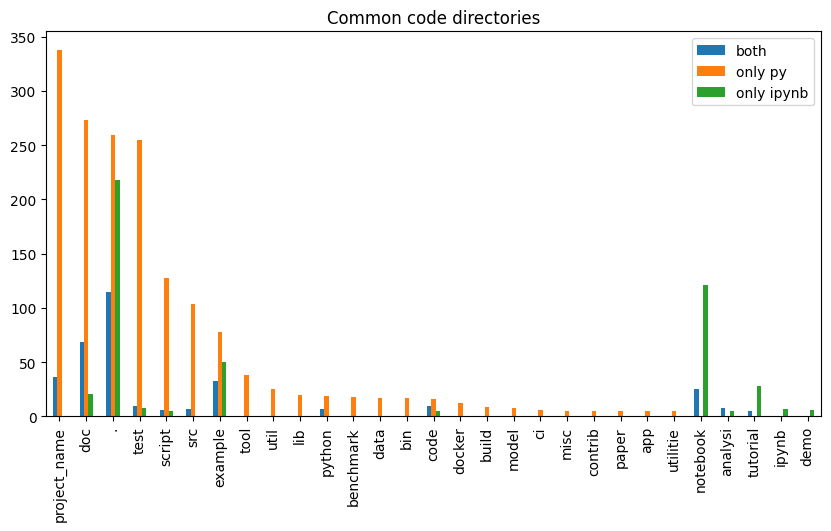

In [ ]:

common_dirs = pd.concat({"both": both, "only py": only_py, "only ipynb": only_ipynb}, axis=1)
common_dirs.sort_values("only py", ascending=False, inplace=True)
common_dirs.plot.bar(figsize=(10,5), title="Common code directories")

#### Do projects have >1 folders with py/ipynb files?

<Axes: >

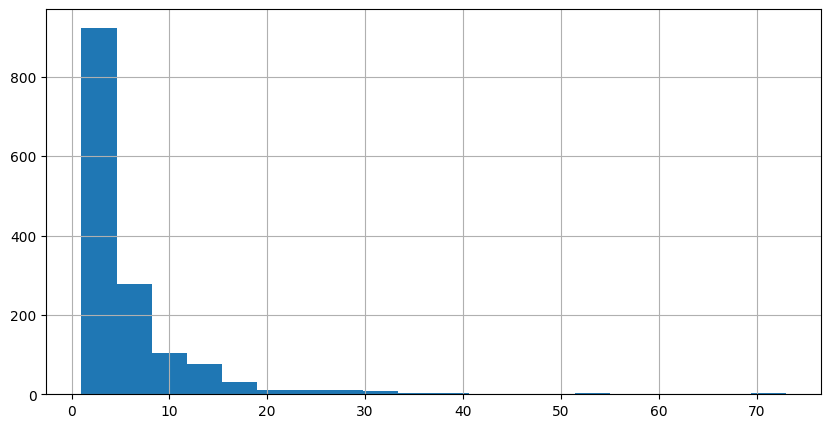

In [ ]:
codedirs_numbers_df =  pd.concat({"both": both_df.sum(axis=1), "only py": only_py_df.sum(axis=1), "only ipynb": only_ipynb_df.sum(axis=1)}, axis=1)
codedirs_numbers_df["sum"] = codedirs_numbers_df.sum(axis=1)
codedirs_numbers_df.sort_values("sum", ascending=False, inplace=True)
codedirs_numbers_df["sum"].hist(bins=20, figsize=(10,5))

## Dependency declaration

In [ ]:
depsfiles = defaultdict(list)
for d in data_biomed.values():
    if d["project_name"] in python_projects:
        if d["deps_file"]:
            depsfiles[d["project_name"]] = d["deps_file"]
        else:
            depsfiles[d["project_name"]] = {}


    # "deps_file": [
    #     {
    #         "source_type": "DepsSource",
    #         "path": "setup.py",
    #         "parser_choice": "setup.py",
    #         "deps_count": 0,
    #         "warnings": true
    #     },
# df_depsfiles = pd.DataFrame.from_dict(depsfiles, orient="index")
print({dd.get("source_type") for d in depsfiles.values() for dd in d})
print({dd.get("parser_choice") for d in depsfiles.values() for dd in d})



{'DepsSource'}
{'requirements.txt', 'pyproject.toml', 'setup.py', 'setup.cfg'}


In [ ]:

threshold = 0

parser_choice = [len({entry["parser_choice"] for entry in v if entry["deps_count"]>threshold})  for _, v in depsfiles.items() if v]

print(len(depsfiles), 
 len(parser_choice), 
 len([v for v in parser_choice if v > 1]), 
 len([v for v in parser_choice if v > 2]), 
 len([v for v in parser_choice if v > 3]))


1113 677 163 3 0


In [ ]:
# Sanity check - consistency between parser choice and names
from collections import Counter
parsed_files = defaultdict(list)
for k, v in depsfiles.items():
    for entry in v:
       if entry["deps_count"]>0:
           parsed_files[entry["parser_choice"]].append(entry["path"].split("/")[-1])


{k: Counter(v) for k, v in parsed_files.items()}


{'requirements.txt': Counter({'requirements.txt': 511,
          'dev-requirements.txt': 38,
          'test-requirements.txt': 26,
          'requirements_pip.txt': 24,
          'requirements-dev.txt': 22,
          'pinned-requirements.txt': 9,
          'requirements_conda.txt': 9,
          'conda_requirements.txt': 6,
          'requirements_dev.txt': 6,
          'requirements.in': 5,
          'doc-requirements.txt': 5,
          'test_requirements.txt': 5,
          'doc_requirements.txt': 5,
          'pip_requirements.txt': 4,
          'requirements_docs.txt': 4,
          'requirements_for_rdt.txt': 3,
          'rtd-requirements.txt': 3,
          'requirements_test.txt': 3,
          'docs-requirements.txt': 3,
          'driver_requirements.txt': 3,
          'lint-requirements.txt': 3,
          'requirements-doc.txt': 3,
          'requirements.dev.txt': 2,
          'requirements_doc.txt': 2,
          'rtd_requirements.txt': 2,
          'readthedocs_requirements.tx

In [ ]:
# Sanity check - what % of setup.py files emit warnings?

warnings_setup_files = [(entry["warnings"], entry["deps_count"]) for k, v in depsfiles.items() for entry in v if entry["parser_choice"] == "setup.py"]

print("Just warnings: ", len(warnings_setup_files), sum([i for i, _ in warnings_setup_files]),
      sum([i for i,_ in warnings_setup_files])/len(warnings_setup_files))

print("Warnings, but dependencies found: ", len(warnings_setup_files), sum([i for i, j in warnings_setup_files if j>0]),
      sum([i for i,j in warnings_setup_files if j>0])/sum([i for i,_ in warnings_setup_files]))


print("Warnings with found deps compared to allfound deps: ", len([i for i,j in warnings_setup_files if j>0]), sum([i for i, j in warnings_setup_files if j>0]),
      sum([i for i,j in warnings_setup_files if j>0])/len([i for i,j in warnings_setup_files if j>0]))


Just warnings:  576 320 0.5555555555555556
Warnings, but dependencies found:  576 145 0.453125
Warnings with found deps compared to allfound deps:  278 145 0.5215827338129496


It looks like half of the setup.py files are not used to declare dependencies.

### Check if existence of dependency declaration is somehow correlated with the project structure.


Declared deps percent: 61.0
Undeclared deps percent: 39.0

 only_ipynb_df


no_deps  declared_deps  all  % all - no_deps
notebook       57             55  112             50.9
tutorial        3             22   25             12.0
doc             5             13   18             27.8
binder          1              5    6             16.7
ipynb           2              4    6             33.3


 only_py_df


no_deps  declared_deps  all  % all - no_deps
project_name       11            288  299              3.7
doc                16            232  248              6.5
script             52             64  116             44.8
src                31             66   97             32.0
tool                2             32   34              5.9


 both_df


no_deps  declared_deps  all  % all - no_deps
doc                 0             53   53              0.0
project_name        2             28   30              6.7
notebook           11             11   22             50.0
code                9              2   11             81.8
analysi             8              1    9             88.9


 total


no_deps  declared_deps  all  % all - no_deps
project_name       13            316  329              4.0
doc                21            298  319              6.6
notebook           68             67  135             50.4
script             57             68  125             45.6
src                35             68  103             34.0

<Axes: title={'center': '% of projects with undeclared deps'}>

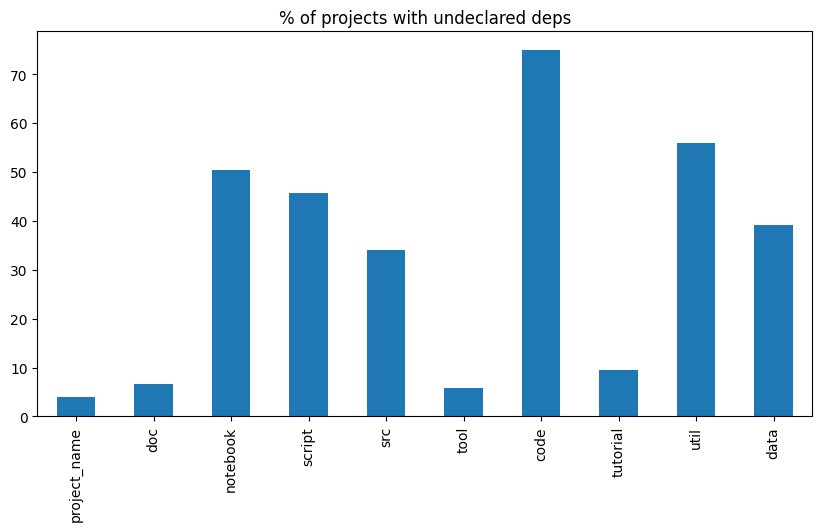

In [ ]:
projects_without_deps = [k for k, v in depsfiles.items() if not v]
projects_with_deps = [k for k, v in depsfiles.items() if v]

dfs = {'only_ipynb_df': only_ipynb_df, 'only_py_df': only_py_df, 'both_df': both_df,
       'total': only_ipynb_df.add(only_py_df, fill_value=0).add(both_df, fill_value=0) }

print("Declared deps percent:", np.round(len(projects_with_deps) / len(depsfiles) * 100))
print("Undeclared deps percent:", np.round(len(projects_without_deps) / len(depsfiles) * 100))

declared_deps_split = {}
for name, df in dfs.items():
    print("\n", name)
    res1 = group_codedirs(df.loc[projects_without_deps,:], threshold=0)
    res2 = group_codedirs(df.loc[projects_with_deps,:], threshold=0)
    res3 = group_codedirs(df, threshold=0)
    declared_deps_split[name] = pd.concat({"no_deps": res1, "declared_deps": res2, "all": res3}, axis=1)
    declared_deps_split[name]["% all - no_deps"] = np.round(declared_deps_split[name]["no_deps"] / declared_deps_split[name]["all"], 3) * 100   
    display(declared_deps_split[name].sort_values("all", ascending=False).head())
    declared_deps_split[name].fillna(0, inplace=True)

declared_deps_split["total"][["% all - no_deps", "all"]].sort_values("all", ascending=False).head(10)["% all - no_deps"].plot.bar(figsize=(10,5), title="% of projects with undeclared deps")